In [1]:
import pandas as pd
import numpy as np

labels = pd.read_csv('labels.csv')

In [2]:
# get dogbreed list
dogbreed_strlist = labels['breed'].unique()
NumberClass = len(dogbreed_strlist)
labels['index'] = 0

In [3]:
#set breed_list index for labels
for i in range(NumberClass):
    labels.loc[labels['breed'] == dogbreed_strlist[i],'index'] = i

In [4]:
#get vgg16 feature for train 
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import sys,time
POOLING = 'avg'
data = []
model = VGG16(weights='imagenet', include_top=False,pooling=POOLING)
for i in labels.index:
    img_path = 'train/'+labels['id'][i]+'.jpg'
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x,batch_size=32)
    data.append(features)
    sys.stdout.write('{0}/12222\r'.format(i + 1))
    sys.stdout.flush()
data_nd = np.asarray(data)


Using TensorFlow backend.


In [6]:
# make own backend
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

X = data_nd.reshape(data_nd.shape[0],-1)
y = keras.utils.to_categorical(labels['index'], num_classes=NumberClass)

mindex = np.asarray(labels.index)
np.random.shuffle(mindex)

X_train = X[mindex[:-1000]]
y_train = y[mindex[:-1000]]
X_test = X[mindex[-1000:]]
y_test = y[mindex[-1000:]]


In [11]:
# define model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1982)
logreg.fit(X_train,(y_train*range(NumberClass)).sum(axis=1))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1982, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
logreg.score(X_test,(y_test*range(NumberClass)).sum(axis=1))

0.66700000000000004

In [13]:
logreg.score(X_train,(y_train*range(NumberClass)).sum(axis=1))

0.99956625460854476

In [15]:
pred_train = logreg.predict(X_train)

In [21]:
pred_decode = dogbreed_strlist[pred_train.astype('int')]

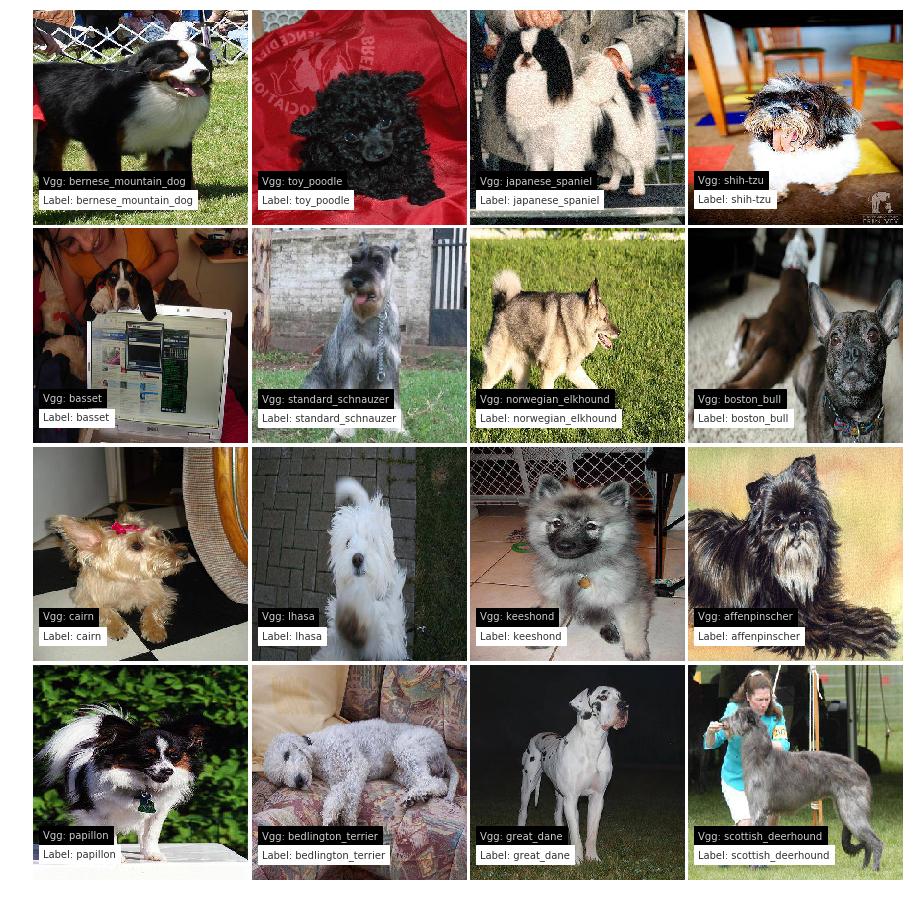

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1,figsize=(16,16))
grid = ImageGrid(fig,111,nrows_ncols=(4,4),axes_pad=0.05)

for i in range(16):
    ax = grid[i]
    img = image.load_img('train/'+labels['id'][mindex[i]]+'.jpg',target_size=(224, 224))
    img = image.img_to_array(img)
    ax.imshow(img/255.)
    ax.text(10,180,'Vgg: %s' %(pred_decode[i]),color='w',backgroundcolor='k',alpha=0.8)
    ax.text(10,200,'Label: %s' % labels['breed'][mindex[i]],color='k',backgroundcolor='w',alpha=0.8)
    ax.axis('off')
    
plt.show()    